<a href="https://colab.research.google.com/github/duTianze/machine-learning/blob/master/Picture_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 下载数据

In [1]:
!pip3 install kaggle
!kaggle
!echo "{\"username\":\"dutianze\",\"key\":\"ff2944c6219d449b37460827c4414422\"}" > /root/.kaggle/kaggle.json
!kaggle datasets download -d dutianze/processmri
!apt-get install zip
!unzip -q ./processmri.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 489, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2793, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2411, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2417, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_d

### import

In [0]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

###构建数据

In [0]:
SIZE = (256, 256)

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def resize_process(data):
    img = Image.open(data)
    img = img.resize(SIZE,Image.ANTIALIAS)
    return img

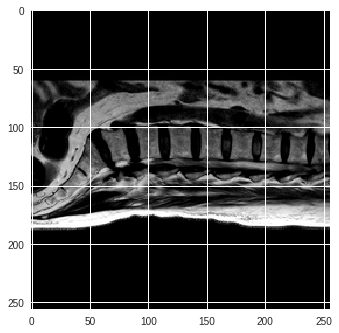

In [5]:
im_array = np.array(resize_process('./MRI/image/Case1.nii.gz_4.png'))
plt.imshow(im_array, cmap ='gray')

In [6]:
im_array.shape

(256, 256)

### 展示图片

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
def show_image(file_name):
  base_dir1 = os.path.join('./MRI/image')
  base_dir2 = os.path.join('./MRI/marked')
  plt.figure(figsize=(15,15))
  img1 = Image.open(os.path.join(base_dir1, file_name))
  plt.subplot(221); plt.imshow(img1, cmap ='gray')
  img2 = Image.open(os.path.join(base_dir2, file_name))
  plt.subplot(222); plt.imshow(img2, cmap ='gray')
  plt.show()

In [0]:
def show_np(np):
  im = Image.fromarray(np)
  plt.figure(figsize=(15,15))
  plt.subplot(221)
  plt.imshow(im, cmap ='gray')
  plt.show()

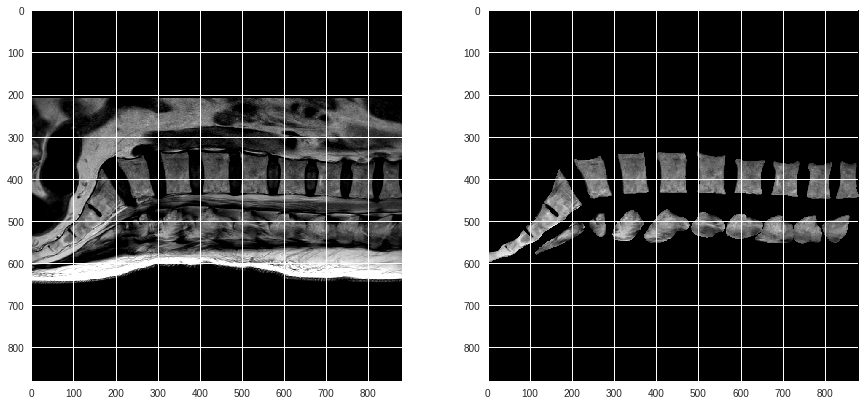

In [9]:
show_image('Case1.nii.gz_5.png')

### 创建generate

In [0]:
def generate_data(directory, batch_size):
    i = 0
    file_list = os.listdir(directory + '/image')
    while True:
        image_batch = []
        marked_batch = []
        for b in range(batch_size):
            if i == len(file_list):
                i = 0
                random.shuffle(file_list)
            sample = file_list[i]
            i += 1
            
            file_dir_img = os.path.join(directory,'image', sample)
            file_dir_mark = os.path.join(directory, 'marked', sample)
 
            im_array = np.array(resize_process(file_dir_img))
            image_batch.append(im_array.astype(float) / 255)
    
            mark_array = np.array(resize_process(file_dir_mark))
            marked_batch.append(mark_array.astype(float) / 255)

        yield np.array(image_batch).reshape(batch_size, 256, 256,1), np.array(marked_batch).reshape(batch_size, 256, 256,1)

In [34]:
a, b = next(generate_data('./MRI', 4))
a.shape
b.shape

(4, 256, 256, 1)

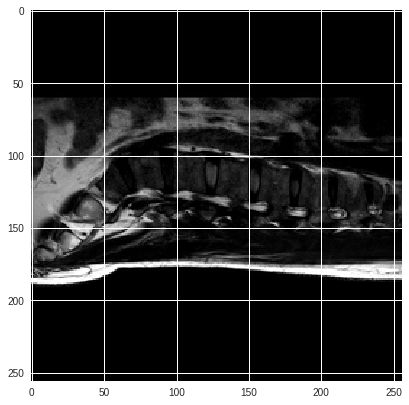

In [35]:
show_np(a[2].reshape(256,256))

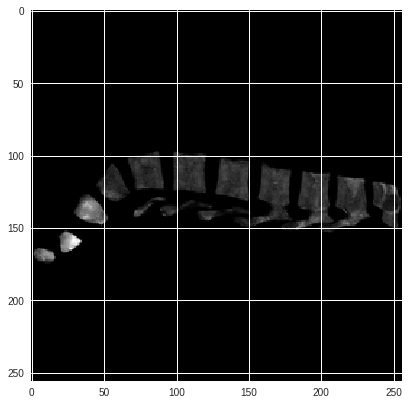

In [36]:
show_np(b[2].reshape(256, 256))

### 构建网络

In [0]:
%matplotlib inline
import cv2
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

In [15]:
model = unet()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


### 训练模型

In [70]:
train_generator = generate_data('./MRI', 1)
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# Decoder Layers
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 256, 256, 256)     2560      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 128, 128, 128)     295040    
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 64, 64, 64)        73792     
__________

In [72]:
history = autoencoder.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=100,
    verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 90ms/step - loss: 0.0841
Epoch 2/100
10/10 [==============================] - 1s 87ms/step - loss: 0.1030
Epoch 3/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0909
Epoch 4/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0865
Epoch 5/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0933
Epoch 6/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0815
Epoch 7/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0923
Epoch 8/100
10/10 [==============================] - 1s 86ms/step - loss: 0.0905
Epoch 9/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0881
Epoch 10/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0990
Epoch 11/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0877
Epoch 12/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0738
Epoch 13/100
10/10 [=====

### 预测

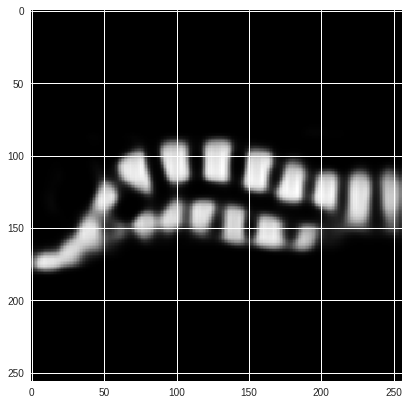

In [73]:
a, b = next(generate_data('./MRI', 4))
c = autoencoder.predict(a)
show_np(c[1].reshape(256,256))